# **NHẬP MÔN HỌC MÁY**
## **PHASE 3- RNN**
### Lớp: CQ2022/24
### Thông tin thành viên
|MSSV|Họ và tên|
|-|-|
|22120214| Trương Thị Tú My|
|22120389| Dương Ngọc Kiều Trinh|
|22120422| Nguyễn Phạm Tú Uyên|
#
---

### Import

In [ ]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import optuna
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Thiết bị: ưu tiên GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hàm để thiết lập seed để kết quả  mô hình có thể tái lập được
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Đọc dữ liệu

Hàm đọc dữ liệu từ file json

In [4]:
def load_data(json_path, is_train=True):
    '''(str, bool) -> list
    Hàm này đọc dữ liệu từ file json và trả về một list các dictionary.
    
    Mỗi dictionary chứa các thông tin sau:
    - vid_id: id của video
    - start_time: thời gian bắt đầu của clip trong video
    - end_time: thời gian kết thúc của clip trong video
    - audio_embedding: numpy array chứa các đặc trưng âm thanh của clip
    - is_turkey: nhãn cho bài toán phân loại (nếu là train)

    Tham số
    -------
    json_path: đường dẫn đến file json chứa dữ liệu
    is_train: True nếu là dữ liệu train, False nếu là dữ liệu test
    '''
    with open(json_path, 'r') as f:
        data = json.load(f)

    records = []
    for item in data:
        embedding = np.array(item['audio_embedding'])  # (frames, 128)
        record = {
            'vid_id': item['vid_id'],
            'start_time': item['start_time_seconds_youtube_clip'],
            'end_time': item['end_time_seconds_youtube_clip'],
            'audio_embedding': embedding
        }
        if is_train:
            record['is_turkey'] = item['is_turkey']
        records.append(record)
    return records

Đọc dữ liệu từ file json

In [5]:
# Đọc dữ liệu huấn luyện
train_data = load_data('../data/train.json', is_train=True)

### **I. Xây dựng Mô hình**

#### 1. Chuẩn bị dữ liệu

Hàm chuẩn hóa độ dài chuỗi embedding bằng cách cắt hoặc padding về độ dài cố định. 

In [6]:
def extract_sequences_labels(records, max_len=10):
    X, y = [], []
    for r in records:
        emb = np.array(r["audio_embedding"])
        if len(emb) > max_len:
            emb = emb[:max_len]
        elif len(emb) < max_len:
            pad = np.zeros((max_len - len(emb), emb.shape[1]))
            emb = np.vstack([emb, pad])
        X.append(emb)
        if "is_turkey" in r:
            y.append(r["is_turkey"])
    X = np.stack(X)
    y = np.array(y) if y else None
    return X, y

Chia tập train thành 3 phần train, validation và test với tỷ lệ 70:15:15

In [7]:
X, y = extract_sequences_labels(train_data)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (835, 10, 128)
Validation: (180, 10, 128)
Test: (180, 10, 128)


#### 2. Huấn luyện mô hình

Tạo các tập dataset và dataloader cho huấn luyện, kiểm tra và đánh giá mô hình.

In [8]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(X_train, y_train)
valid_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Dataset gộp train + val để dùng huấn luyện mô hình cuối cùng
trainval_dataset = AudioDataset(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Mô hình LSTM kết hợp attention để phân loại âm thanh tiếng gà tây.

In [9]:
class TurkeyClassifierLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, dropout=0.4, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        direction_factor = 2 if bidirectional else 1
        self.attention = nn.Linear(hidden_size * direction_factor, hidden_size)
        self.classifier = nn.Linear(hidden_size * direction_factor, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size * directions)
        attn_scores = torch.tanh(self.attention(lstm_out))
        attn_weights = F.softmax(attn_scores.sum(dim=2), dim=1).unsqueeze(2)
        context = torch.sum(lstm_out * attn_weights, dim=1)
        out = self.classifier(context)
        return out

Early stopping để ngăn overfitting trong quá trình huấn luyện.

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.counter = 0
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if self.verbose:
                print(f"Improved val score: {self.best_score:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in val score for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True

    def get_best_model_state(self):
        return self.best_model_state

Sử dụng Optuna để tối ưu siêu tham số cho mô hình LSTM với kỹ thuật Stratified K-Fold Cross Validation và Early Stopping.

In [11]:
def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    val_auc_scores = []

    train_X_np = X_train
    train_y_np = y_train

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X_np, train_y_np)):
        fold_train_ds = AudioDataset(train_X_np[train_idx], train_y_np[train_idx])
        fold_val_ds = AudioDataset(train_X_np[val_idx], train_y_np[val_idx])
        fold_train_loader = DataLoader(fold_train_ds, batch_size=batch_size, shuffle=True)
        fold_val_loader = DataLoader(fold_val_ds, batch_size=batch_size)

        model = TurkeyClassifierLSTM(128, hidden_size, num_layers, dropout, bidirectional).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        early_stopping = EarlyStopping(patience=3, verbose=False)

        for _ in range(5):
            model.train()
            train_loss = 0.0
            for xb, yb in fold_train_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            y_true, y_pred, y_scores = [], [], []
            with torch.no_grad():
                for xb, yb in fold_val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item()

                    probs = torch.softmax(out, dim=1)[:, 1]
                    pred = torch.argmax(out, dim=1)

                    y_true.extend(yb.cpu().numpy())
                    y_pred.extend(pred.cpu().numpy())
                    y_scores.extend(probs.cpu().numpy())

            val_loss /= len(fold_val_loader)
            try:
                val_auc = roc_auc_score(y_true, y_scores)
            except:
                val_auc = 0.0

            early_stopping(val_auc, model)
            if early_stopping.early_stop:
                break

        # Lưu AUC tốt nhất cho fold này
        val_auc_scores.append(early_stopping.best_score or 0.0)

    return sum(val_auc_scores) / len(val_auc_scores)

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

[I 2025-06-08 22:45:44,638] A new study created in memory with name: no-name-8044718d-47dc-4f68-9228-596c9b17f2a9
[I 2025-06-08 22:47:12,515] Trial 0 finished with value: 0.9841638583964499 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.41834850844856375, 'lr': 0.0038727966216806783, 'batch_size': 64, 'bidirectional': True}. Best is trial 0 with value: 0.9841638583964499.
[I 2025-06-08 22:47:31,273] Trial 1 finished with value: 0.9794117647058822 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.10135981326341814, 'lr': 0.00014742639475276784, 'batch_size': 32, 'bidirectional': False}. Best is trial 0 with value: 0.9841638583964499.
[I 2025-06-08 22:47:37,504] Trial 2 finished with value: 0.9622724188938195 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4028872638023794, 'lr': 0.0003121443147916764, 'batch_size': 64, 'bidirectional': False}. Best is trial 0 with value: 0.9841638583964499.
[I 2025-06-08 22:47:43,537] Trial 3 finish

Best hyperparameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.363942911482769, 'lr': 0.0011781274340719025, 'batch_size': 64, 'bidirectional': True}
Best ROC AUC: 0.9868417247783969


Đánh giá các mô hình trên tập train và valid

In [13]:
# Huấn luyện trên train và đánh giá trên valid
best_params = study.best_params
batch_size = best_params["batch_size"]

model = TurkeyClassifierLSTM(
    input_size=128,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    bidirectional=best_params.get("bidirectional", False)  # nếu có
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 30
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Đánh giá trên valid sau mỗi epoch
    model.eval()
    y_true_val, y_scores_val = [], []
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            probs = torch.softmax(out, dim=1)[:, 1]
            y_true_val.extend(yb.cpu().numpy())
            y_scores_val.extend(probs.cpu().numpy())
    val_auc = roc_auc_score(y_true_val, y_scores_val)
    print(f"Epoch {epoch+1}, Validation ROC AUC: {val_auc:.4f}")

    early_stopping(val_auc, model)
    if early_stopping.early_stop:
        print(f"Stopped early at epoch {epoch+1}")
        break

Epoch 1, Validation ROC AUC: 0.9723
Improved val score: 0.9723
Epoch 2, Validation ROC AUC: 0.9749
Improved val score: 0.9749
Epoch 3, Validation ROC AUC: 0.9714
No improvement in val score for 1 epochs
Epoch 4, Validation ROC AUC: 0.9765
Improved val score: 0.9765
Epoch 5, Validation ROC AUC: 0.9759
No improvement in val score for 1 epochs
Epoch 6, Validation ROC AUC: 0.9734
No improvement in val score for 2 epochs
Epoch 7, Validation ROC AUC: 0.9739
No improvement in val score for 3 epochs
Stopped early at epoch 7


In [14]:
def visualize_evaluation(y_true, y_pred, y_scores, name="Evaluation"):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc_val = auc(fpr, tpr)

    # Classification Report (as dict → DataFrame)
    report = classification_report(y_true, y_pred, target_names=['Non-Turkey', 'Turkey'], output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Remove 'accuracy' row

    # Plotting
    fig = plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Turkey', 'Turkey'],
                yticklabels=['Non-Turkey', 'Turkey'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.subplot(1, 3, 2)
    sns.heatmap(report_df, annot=True, cmap='Blues', cbar=False, fmt=".2f")
    plt.title('Classification Report Metrics')
    plt.yticks(rotation=0)

    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    
def evaluate_model(model, dataloader, device, name="Validation Set"):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = torch.argmax(out, dim=1)
            
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"{name} Classification Report:\n{classification_report(y_true, y_pred)}")

    # Gọi trực quan hóa
    visualize_evaluation(y_true, y_pred, y_scores, name=name)

In [15]:
# Tạo lại mô hình giống hệt như khi training
best_model = TurkeyClassifierLSTM(
    input_size=128,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    bidirectional=best_params.get("bidirectional", False)
).to(device)

# Load trọng số tốt nhất từ early_stopping
best_model.load_state_dict(early_stopping.get_best_model_state())

<All keys matched successfully>

Train Set Accuracy: 0.9401
Train Set ROC AUC: 0.9876
Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       492
           1       0.89      0.97      0.93       343

    accuracy                           0.94       835
   macro avg       0.94      0.94      0.94       835
weighted avg       0.94      0.94      0.94       835



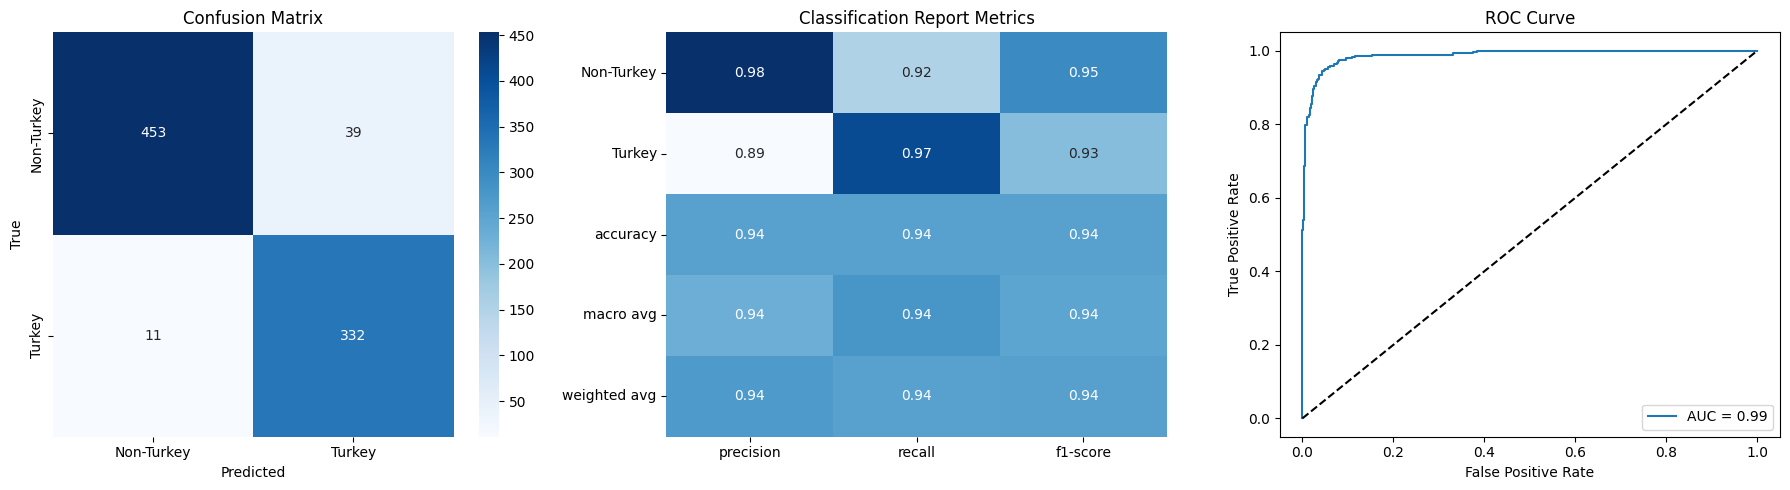

Validation Set Accuracy: 0.9056
Validation Set ROC AUC: 0.9765
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       106
           1       0.85      0.93      0.89        74

    accuracy                           0.91       180
   macro avg       0.90      0.91      0.90       180
weighted avg       0.91      0.91      0.91       180



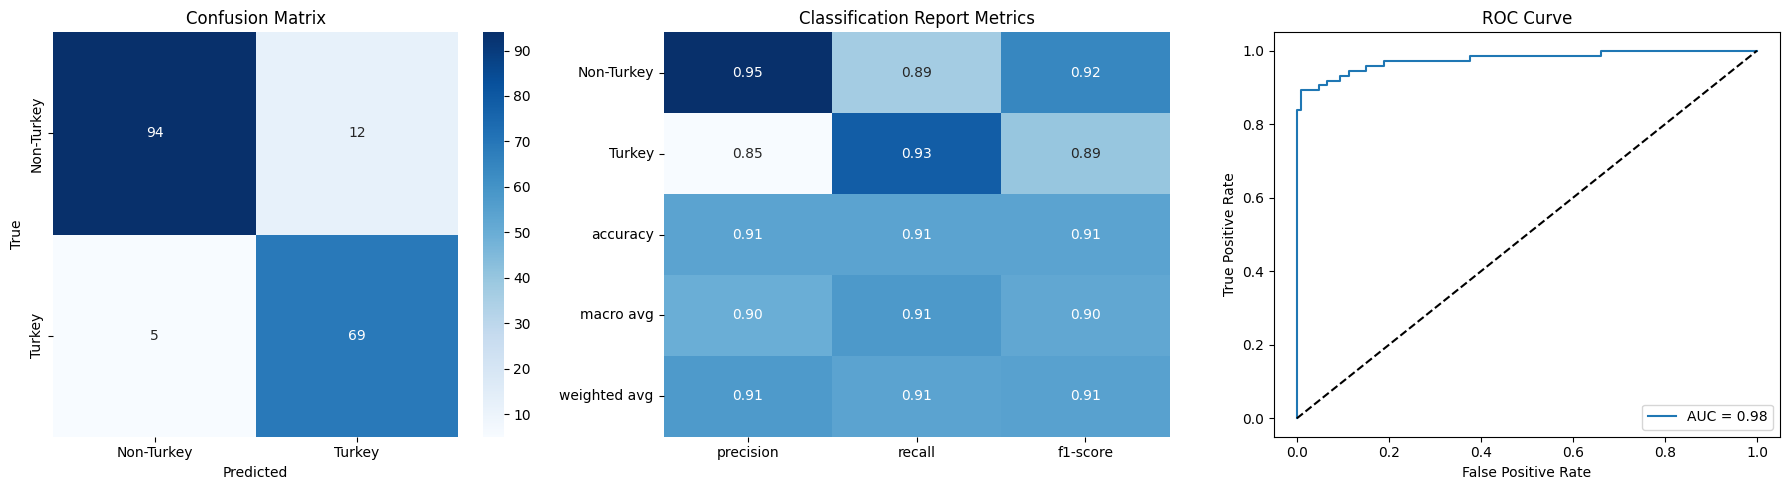

In [16]:
evaluate_model(best_model, train_loader, device, name="Train Set")
evaluate_model(best_model, valid_loader, device, name="Validation Set")

**Nhận xét**

- Tập train:

    - Confusion matrix cho thấy mô hình phân loại rất chính xác: chỉ có 33 mẫu Non-Turkey bị nhầm thành Turkey và 13 mẫu Turkey bị nhầm sang Non-Turkey.

    - Precision, Recall và f1-score cho cả hai lớp đều rất cao, điều này cho thấy mô hình học gần như được hoàn toàn cấu trúc của tập huấn luyện.

    - AUC 0.99 trên đường cong ROC cho thấy khả năng phân biệt hai lớp của mô hình gần như tuyệt đối trên tập train.
    
    - Mô hình thế hiện tốt trên tập huấn luyện, là dấu hiệu rõ ràng có khả năng đã học rất kỹ dữ liệu huấn luyện, cần kiểm tra kỹ hơn ở các tập còn lại để đánh giá mức độ tổng quát.

- Tập validation:

    - Các chỉ số tổng quát như accuracy và AUC vẫn rất cao cho thấy mô hình vẫn có khả năng phân loại mạnh mẽ và ổn định.

    - Tuy nhiê, lớp Turkey bắt đầu có dấu hiệu mô hình hơi dè dặt khi precision chỉ còn 0.85 nhưng recall vẫn rất cao, chứng tỏ mô hình ít bỏ sót Turkey nhưng đôi khi dự đoán nhầm.
    
    - Mô hình đã bắt đầu cho thấy hiệu năng giảm nhẹ khi chuyển sang dữ liệu không thấy trong quá trình huấn luyện nhưng nhìn chung vẫn giữ được độ ổn định và không có dấu hiệu overfitting nghiêm trọng.

### **II. Đánh giá mô hình**

Dự đoán trên tập test và đánh giá mô hình


--- Kết quả đánh giá trên test có nhãn ---
Test Labeled Set Accuracy: 0.9333
Test Labeled Set ROC AUC: 0.9898
Test Labeled Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       106
           1       0.90      0.95      0.92        74

    accuracy                           0.93       180
   macro avg       0.93      0.94      0.93       180
weighted avg       0.93      0.93      0.93       180



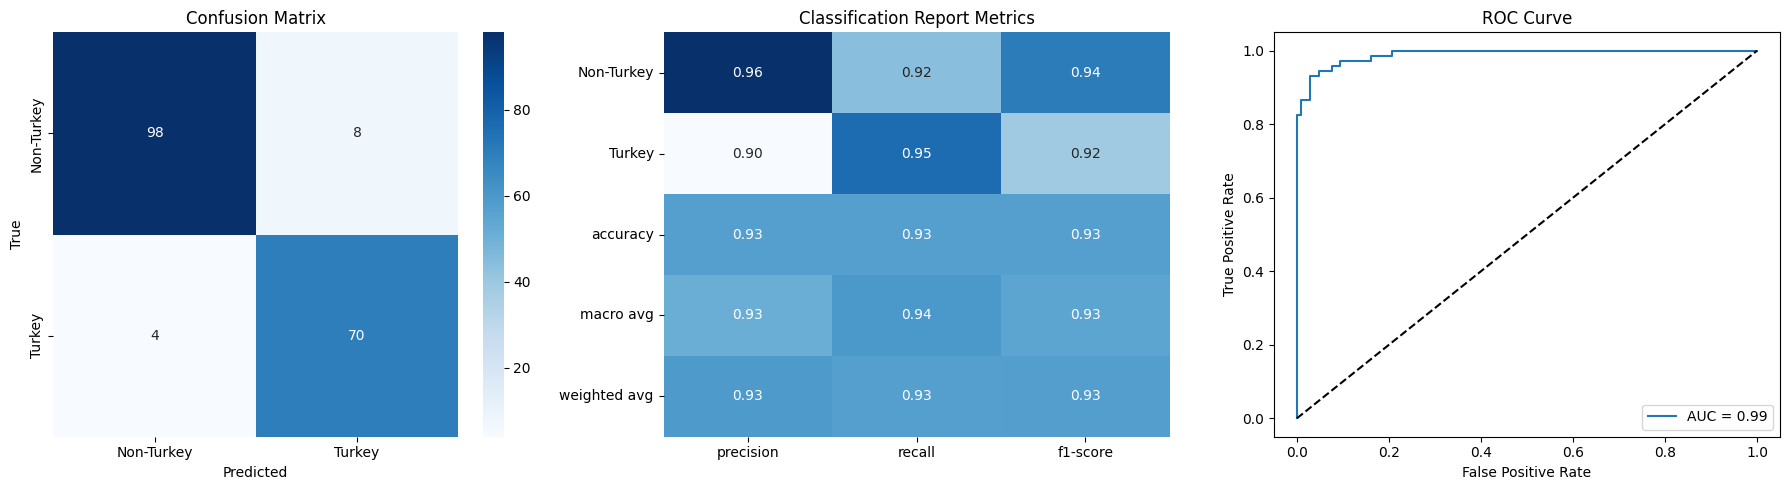

In [17]:
# Đánh giá trên test có nhãn
print("\n--- Kết quả đánh giá trên test có nhãn ---")
evaluate_model(best_model, test_loader, device, name="Test Labeled Set")

**Nhận xét**

-	Accuracy tăng nhẹ lên 0.93 cho thấy mô hình không những ổn định mà còn có thể hoạt động tốt ngoài tập huấn luyện.

-	Precision và reacll cho cả hai lớp đều được cải thiện nhẹ so với validation.

-	Nhìn chung, mô hình có hiệu năng cao trên tất cả các tập huấn luyện. Các chỉ số đánh giá đều ổn định và ở mức tốt cho thấy mô hình học được đặc trưng phân loại thực sự hữu ích. Mô hình duy trì hiệu năng rất tốt thể hiện khả năng tổng quát hóa cao và ổn định, không chỉ hoạt động tốt trên dữ liệu huấn luyện mà còn đáng tin cậy với dữ liệu chưa thấy.

### Dự đoán kết quả của tập test ẩn

Ta dự đoán kết quả của tập test ẩn và lưu lại.

In [18]:
best_model.eval()

# Load và xử lý dữ liệu test (không có nhãn)
test_data = load_data('../data/test.json', is_train=False)
X_test_hidden, _ = extract_sequences_labels(test_data)

# Tạo tensor và DataLoader
test_tensor = torch.tensor(X_test_hidden, dtype=torch.float32)
test_dataset = torch.utils.data.TensorDataset(test_tensor)  # vì không có label
test_loader = DataLoader(test_dataset, batch_size=32)

# Dự đoán
test_probs = []
vid_ids = [r['vid_id'] for r in test_data]

with torch.no_grad():
    for (x_batch,) in test_loader:  # unpack 1 phần tử tuple
        x_batch = x_batch.to(device)
        outputs = best_model(x_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Xác suất lớp "Turkey"
        test_probs.extend(probs.cpu().numpy())

submission_df = pd.DataFrame({
    'vid_id': vid_ids,
    'is_turkey': test_probs
})
submission_df.to_csv('result_rnn.csv', index=False)

print("Đã lưu kết quả dự đoán vào 'result_rnn.csv'")

Đã lưu kết quả dự đoán vào 'result_rnn.csv'
